In [1]:
#TODO
# 1.詢問助教是否是使用新的trainingdata和新的testingdata，如果是那就要做完善的洗資料，因為testingdata中就有一筆資料是有缺失的(blank)
# 2.詢問是否要用儲存成一個model，然後去跑助教的testingdata，並且在20天內得到最高的profit
# 3.重新判斷和確認high,low和close收盤價的關係
# 4.改模型參數LSTM 256->64， batch_size, learning_rate, epochs, train_test_split_ratio, past_day&future_day交叉測試
# 5.跑requirement.txt
# 6.跑Pipfile
# 7.寫Readme
# 8.ipynb -> py 整合，execute arguments defined
# 9.TestingCorrector

#TOFIX
# 1.每次讀到csv的時候，第一個資料都會被miss掉，去找出原因 
    # Fixed: 只要在read_csv裡面加入header=None就會讓api自動忽略把第一筆資料當做column項了
# 2.把缺失的資料，用predata 和 postdata 的平均補上。目前是直接使用前一筆data

# train出兩套model，第一個先訓練出k線
# 第二個訓練出基於第一個模型訓練出的k線與實際值比對過後的買賣決策

In [2]:
!nvidia-smi

Mon Apr 12 14:39:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from statistics import mean
from numpy import newaxis
import csv

In [5]:
# 以收盤價為train, 以開盤價為target label
def split_dataset(df, past_day, future_day):
  X, Y = [], []
  for i in range(len(df) - future_day - past_day):
    X.append(np.array(df[i:i+past_day, 0]))
    Y.append(np.array(df[i+past_day:i+past_day+future_day, 0]))
  return np.array(X), np.array(Y)


In [6]:
def build_model(shape):
  model = Sequential()
  model.add(LSTM(64, input_shape=(shape[1], shape[2]), return_sequences=True))
  print(shape[1], shape[2])
  model.add(Dropout(0.2))
  model.add(LSTM(64, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  return model 

In [7]:
def generate_csv():
  try:
    with open('output.csv', mode='w') as csv_file:
      writer = csv.writer(csv_file)
      writer.writerow([0])
      writer.writerow([-1])
      writer.writerow([1])
      csv_file.seek(0, os.SEEK_END)
      csv_file.truncate()
  except:
    raise

In [13]:
main_path = 'drive/My Drive/Colab Notebooks/DSAI_HW2'
print(os.listdir(main_path))

['training.csv', 'testing.csv']


In [14]:
# Arguments
epochs = 100
batch_size = 32
past_day = 5
future_day = 1

In [15]:
train_df = pd.read_csv(os.path.join(main_path, 'training.csv'), header=None)
test_df = pd.read_csv(os.path.join(main_path, 'testing.csv'), header=None)

train_df.drop([1,2,3], inplace=True, axis=1)
test_df.drop([1,2,3], inplace=True, axis=1)

test_df = pd.DataFrame(np.insert(test_df.to_numpy(), 0, train_df.to_numpy()[-(past_day+1):], axis=0))
train_df = pd.DataFrame(train_df.to_numpy()[:-(past_day+1)])


# Scaling
sc = MinMaxScaler(feature_range=(-1, 1))
scaled_train_df = sc.fit_transform(train_df)
scaled_test_df  = sc.transform(test_df)

# Generate training data and label
x_train, y_train = split_dataset(scaled_train_df, past_day, future_day)
x_test, y_test = split_dataset(scaled_test_df, past_day, future_day)



In [16]:
# Reshape the data into (Samples, Timestep, Features)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Build model
model = build_model(x_train.shape)
model.summary()

# Compile and Fit
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
model.compile(optimizer=Adam(), loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_test, y_test), shuffle=False, callbacks=[reduce_lr, early_stopping])
model.save('model.h5')


5 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 64)             16896     
_________________________________________________________________
dropout (Dropout)            (None, 5, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 64)             33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
dense (Dense)                (None, 5, 1)              65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [==============================] - 33s 32ms/step - loss: 0.1995 - val_loss: 0.0258
Epoch 2/100
4

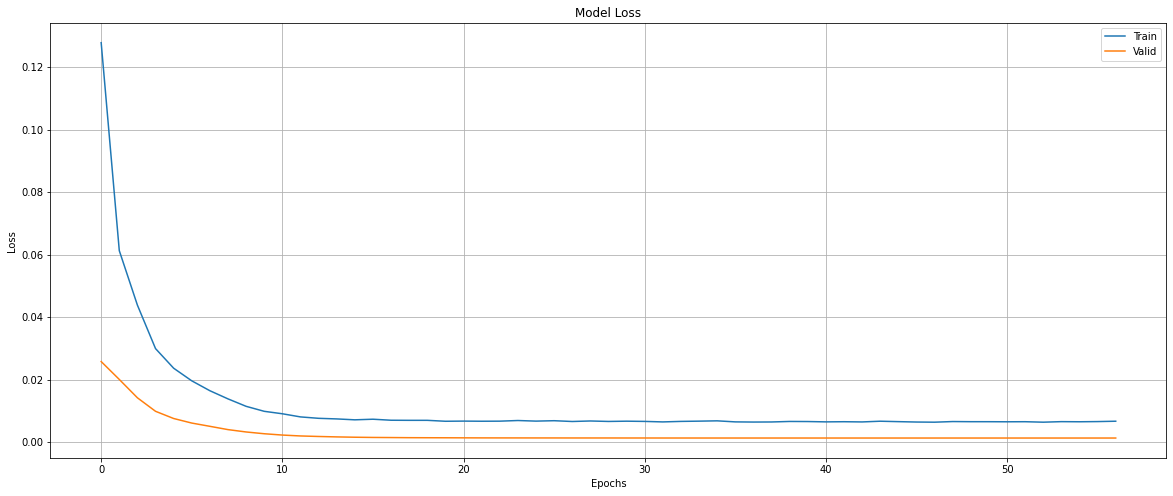

In [17]:
# Plotting
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Valid'])
plt.grid(True)

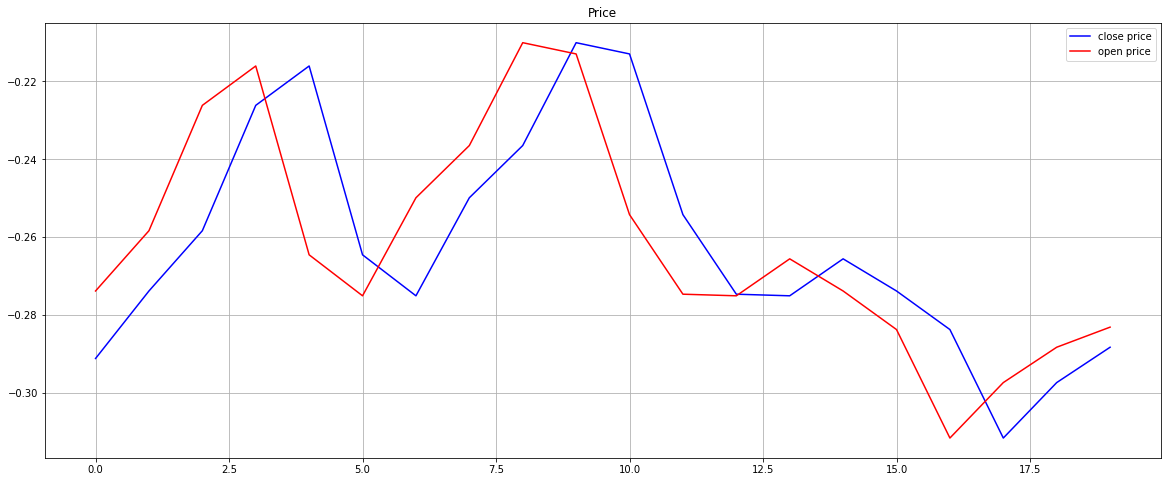

In [18]:
plt.figure(figsize=(20,8))
plt.plot(x_test[:,-1], color='blue')
plt.plot(y_test, color='red')
plt.title("Price")
plt.grid(True)
plt.legend(['close price','open price'])

[155.9674, 156.47795, 154.18933, 153.61177, 154.86592, 155.5585, 156.7566, 156.63362, 154.67831, 153.66151, 153.67888, 154.15009, 153.74466, 153.23778, 151.92056, 152.56638, 153.04521, 152.0345, 152.59547, 153.11887]


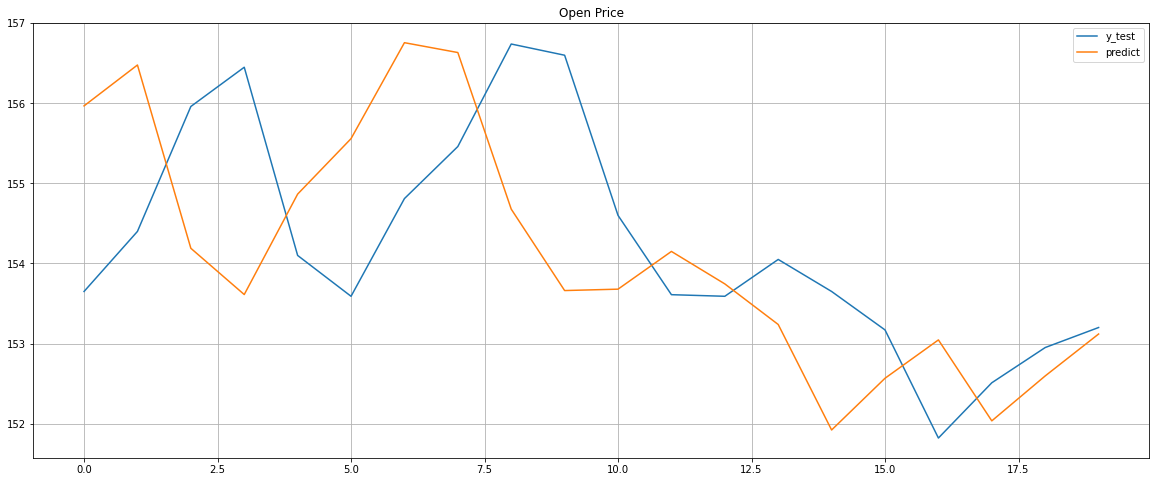

In [21]:
#@title 預設標題文字
predicted = model.predict(x_test)
predict = sc.inverse_transform(predicted.reshape(predicted.shape[0], predicted.shape[1]))

# 將預測data前移三天，並利用預測結果預測剩餘最後三天的股票
last = np.array([x_test[-1, 1:], x_test[-1, 2:], x_test[-1, 3:]], dtype=object)

last[0] = np.array(np.concatenate((np.array(last[0]), np.array(predicted[newaxis, -3, -1]))))
last[1] = np.concatenate((last[1], predicted[newaxis, -3, -1]))
last[1] = np.array(np.concatenate((last[1], predicted[newaxis, -2, -1])))
last[2] = np.concatenate((last[2], predicted[newaxis, -3, -1]))
last[2] = np.concatenate((last[2], predicted[newaxis, -2, -1]))
last[2] = np.array(np.concatenate((last[2], predicted[newaxis, -1, -1])))

last[0] = pd.DataFrame(last[0])
last[1] = pd.DataFrame(last[1])
last[2] = pd.DataFrame(last[2])


X = []
X.append(np.array(last[0]))
X.append(np.array(last[1]))
X.append(np.array(last[2]))
X = np.array(X)

predicted_last = model.predict(X)
predicted_last = sc.inverse_transform(predicted_last.reshape(predicted_last.shape[0], predicted_last.shape[1]))

nu = []
for i in range(20):
  nu.append(predict[i, -1])
nu = nu[3:]
nu.append(predicted_last[0, -1])
nu.append(predicted_last[1, -1])
nu.append(predicted_last[2, -1])
print(nu)

ground_truth = sc.inverse_transform(y_test.reshape(-1,1))

plt.figure(figsize=(20,8))
plt.plot(ground_truth)
plt.plot(nu)
plt.title('Open Price')
plt.legend(['y_test','predict'])
plt.grid(True)

In [23]:
print(nu)

# 1: buy
# 0: hold
#-1: sell
status = 0;
flag = 0;
revenue = 0;

with open('output.csv', mode='w') as csv_file:
  writer = csv.writer(csv_file)
  writer.writerow(['actoin table'])
  for i in range(19):
    if (status == 1):
      if (nu[i+1]<nu[i]):
        writer.writerow(['-1'])
        status = 0
        revenue = revenue+nu[i]
      else:
         writer.writerow(['0'])
    elif (status == 0):
      if (nu[i+1]>nu[i]):
        writer.writerow(['1'])
        status = 1
        revenue = revenue-nu[i]
      elif (nu[i+1]<nu[i]):
        writer.writerow(['-1'])
        status = -1
        revenue = revenue+nu[i]
      else: 
        writer.writerow(['0'])
    else :
      if (nu[i+1]>nu[i]):
        writer.writerow(['1'])
        status = 0
        revenue = revenue-nu[i]
      else:
        writer.writerow(['0'])
if (status==1) :
  revenue = revenue + nu[19]
elif (status==-1) :
  revenue = revenue - nu[19] 

print(revenue)

[155.9674, 156.47795, 154.18933, 153.61177, 154.86592, 155.5585, 156.7566, 156.63362, 154.67831, 153.66151, 153.67888, 154.15009, 153.74466, 153.23778, 151.92056, 152.56638, 153.04521, 152.0345, 152.59547, 153.11887]
9.809402465820312
